In [2]:
import plotly.express as px
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.special import expit # Numerically stable sigmoid function
from scipy.optimize import curve_fit

# Import Data

# Set print options to suppress scientific notation
np.set_printoptions(suppress=True)

year = 2014
period = ['may-jun', 'jun-jul']

# Import data
if year == 2014:
    X = np.load('../data/processed/data_2014.npz')

elif year == 2015:
    X = np.load('../data/processed/data_2015.npz')

elif year == 2016:
    X = np.load('../data/processed/data_2016.npz')
    
elif year == 2017:
    X = np.load('../data/processed/data_2017.npz')

N = X['N']

dist = X['distance']
#tI1 = X['tI1'].reshape(N,1)
#tI2 = X['tI2'].reshape(N,1)
sI2 = X['sI2'].reshape(N,1)

y_apr = X['y_apr'].reshape(N,1)
y_may = X['y_may'].reshape(N,1)
y_jun = X['y_jun'].reshape(N,1)
y_jul = X['y_jul'].reshape(N,1)

n_apr = X['n_apr'].reshape(N,1)
n_may = X['n_may'].reshape(N,1)
n_jun = X['n_jun'].reshape(N,1)
n_jul = X['n_jul'].reshape(N,1)

a_apr = X['a_apr'].reshape(N,1)
a_may = X['a_may'].reshape(N,1)
a_jun = X['a_jun'].reshape(N,1)
a_jul = X['a_jul'].reshape(N,1)

w_apr = X['wind_apr']
w_may = X['wind_may']
w_jun = X['wind_jun']
w_jul = X['wind_jul']

sI1_apr = X['sI1_apr'].reshape(N,1)
sI1_may = X['sI1_may'].reshape(N,1)
sI1_jun = X['sI1_jun'].reshape(N,1)
sI1_jul = X['sI1_jul'].reshape(N,1)

s_apr = X['s_apr'].reshape(N,1)
s_may = X['s_may'].reshape(N,1)
s_jun = X['s_jun'].reshape(N,1)
s_jul = X['s_jul'].reshape(N,1)

# Convert to float64
dist = dist.astype(np.float64)
#tI1 = tI1.astype(np.float64)
#tI2 = tI2.astype(np.float64)
sI2 = sI2.astype(np.float64)

y_apr = y_apr.astype(np.float64)
y_may = y_may.astype(np.float64)
y_jun = y_jun.astype(np.float64)
y_jul = y_jul.astype(np.float64)

n_apr = n_apr.astype(np.float64)
n_may = n_may.astype(np.float64)
n_jun = n_jun.astype(np.float64)
n_jul = n_jul.astype(np.float64)

a_apr = a_apr.astype(np.float64)
a_may = a_may.astype(np.float64)
a_jun = a_jun.astype(np.float64)
a_jul = a_jul.astype(np.float64)

w_apr = w_apr.astype(np.float64)
w_may = w_may.astype(np.float64)
w_jun = w_jun.astype(np.float64)
w_jul = w_jul.astype(np.float64)

sI1_apr = sI1_apr.astype(np.float64)
sI1_may = sI1_may.astype(np.float64)
sI1_jun = sI1_jun.astype(np.float64)
sI1_jul = sI1_jul.astype(np.float64)

s_apr = s_apr.astype(np.float64)
s_may = s_may.astype(np.float64)
s_jun = s_jun.astype(np.float64)
s_jul = s_jul.astype(np.float64)


# Function to normalize the data
def norm(x):
    
    return (x - np.min(x)) / (np.max(x) - np.min(x))

# Normalize the data
dist = norm(dist)

a_apr = norm(a_apr)
a_may = norm(a_may)
a_jun = norm(a_jun)
a_jul = norm(a_jul)


# Import Paramaters

if year == 2014:
    
    theta_may_jun = np.load('../reports/parameters/theta_may-jun_2014_SLSQP.npy', allow_pickle=True)
    theta_jun_jul = np.load('../reports/parameters/theta_jun-jul_2014_SLSQP.npy', allow_pickle=True)
    
elif year == 2015:
    
    theta_may_jun = np.load('../reports/parameters/theta_may-jun_2015.npy', allow_pickle=True)
    theta_jun_jul = np.load('../reports/parameters/theta_jun-jul_2015.npy', allow_pickle=True)
    
elif year == 2016:
    
    theta_may_jun = np.load('../reports/parameters/theta_may-jun_2016.npy', allow_pickle=True)
    theta_jun_jul = np.load('../reports/parameters/theta_jun-jul_2016.npy', allow_pickle=True)
    
elif year == 2017:
    
    theta_may_jun = np.load('../reports/parameters/theta_may-jun_2017_1_1.npy', allow_pickle=True)
    theta_jun_jul = np.load('../reports/parameters/theta_jun-jul_2017_1_1.npy', allow_pickle=True)

# Safe exponential function
def safe_exp(x):
    """Prevent overflow of exponential function."""
    # np.finfo('d').max is the maximum representable positive number
    # np.log(np.finfo('d').max) is the maximum number that can be exponentiated without overflow
    # We clamp x to this range before taking the exponent
    x = np.clip(x, None, np.log(np.finfo('d').max))
    return np.exp(x)

# Define the function eta() which takes input parameters theta and returns the log-odds of disease for each yard i in current time period

def eta(period, y_lag, s_lag):
    
    y_lag = y_lag
    
    if period == 'may-jun':
        theta = theta_may_jun
        #y_lag = y_may
        n_lag = n_may
        a_lag = a_may
        w_lag = w_may
        #sI1_lag = sI1_may
        #s_lag = s_may

    elif period == 'jun-jul':
        theta = theta_jun_jul
        #y_lag = y_jun
        n_lag = n_jun
        a_lag = a_jun
        w_lag = w_jun
        #sI1_lag = sI1_jun
        #s_lag = s_jun
        
    beta1, beta2, delta1, delta2, gamma1, gamma2, alpha1, alpha2, eta11, eta12, eta21, eta22 = theta
    
    beta1_array = np.full((N,1), beta1)
    beta2_array = np.full((N,1), beta2)
    
    auto_infection1 = delta1 * (y_lag / n_lag) * np.exp(-eta11 * s_lag)
    auto_infection2 = delta2 * (y_lag / n_lag) * np.exp(-eta12 * s_lag)
    
    dispersal1 = []
    dispersal2 = []
    
    eta_1 = [] 
    
    for i in range(0, N):
        
        dispersal_array = ((a_lag * (y_lag / n_lag)) * (w_lag[:, i].reshape(N,1)))
        dispersal_array1 = dispersal_array * np.exp(-eta21 * s_lag) * np.exp(-alpha1 * dist[:, i].reshape(N,1)) * sI1_lag
        dispersal_array2 = dispersal_array * np.exp(-eta22 * s_lag) * np.exp(-alpha2 * dist[:, i].reshape(N,1)) * sI2
        dispersal_component1_i = gamma1 * (np.sum(dispersal_array1) - dispersal_array1[i][0])
        dispersal_component2_i = gamma2 * (np.sum(dispersal_array2) - dispersal_array2[i][0])
        
        dispersal1.append(dispersal_component1_i)
        dispersal2.append(dispersal_component2_i)
    
    dispersal1 = np.array(dispersal1).reshape(N,1)
    dispersal2 = np.array(dispersal2).reshape(N,1)
    
    eta = tI1 * (beta1_array + auto_infection1 + dispersal1) + tI2 * (beta2_array + auto_infection2 + dispersal2)
    
    eta_1_i = tI1[i] * (auto_infection1 + dispersal1) + tI2[i] * (auto_infection2 + dispersal2)
    eta_1.append(eta_1_i)
    eta_1 = np.array(eta_1).reshape(N,1)
    
    return eta, eta_1


# Probability Function

def prob(period, y_lag, s_lag):
    
    etaa = eta(period, y_lag, s_lag)
    
    p = expit(etaa[0])
    
    for i in range(0, N):
    
        if etaa[1][i] == 0.0:
            
            p[i] = 0.0    
    
    return p

# Read data from CSV file into a pandas DataFrame
df = pd.read_csv('../data/processed/cost_data.csv', encoding='utf-8')

# Revenue Function

In [3]:
# Data for the estimation of cone incidence vs leaf incidence
df_cone_incidence_leaf_incidence = pd.read_csv('../data/raw/economics/Leaf incidence_vs_Cone_incidence.csv', encoding='utf-8')

# Data preprocessing
df_cone_incidence_leaf_incidence = df_cone_incidence_leaf_incidence.dropna()

# Data for the estimation of yield loss vs cone incidence (change in quantity metric)
df_yield_loss_cone_incidence = pd.read_csv('../data/raw/economics/Cone incidence_vs_Cone color_and_Yield.csv', encoding='utf-8')
df_yield_loss_cone_incidence = df_yield_loss_cone_incidence[['Cone incidence', 'Yield Loss']]

# Data for the estimation of cone color vs cone incidence (change in quality metric)
df_cone_color_cone_incidence = pd.read_csv('../data/raw/economics/Cone incidence_vs_Cone color_and_Yield.csv', encoding='utf-8')
df_cone_color_cone_incidence = df_cone_color_cone_incidence[['Cone incidence', 'Cone Color']]


# Data
data_cone_incidence_leaf_incidence = df_cone_incidence_leaf_incidence.to_numpy()
data_yield_loss_cone_incidence = df_yield_loss_cone_incidence.to_numpy()
data_cone_color_cone_incidence = df_cone_color_cone_incidence.to_numpy()

# Regressions

# CONE INCIDENCE VS LEAF INCIDENCE
a1, b1 = np.polyfit(data_cone_incidence_leaf_incidence[:, 0], data_cone_incidence_leaf_incidence[:, 1], 1)

# YIELD LOSS VS CONE INCIDENCE
a2, b2 = np.polyfit(data_yield_loss_cone_incidence[:, 0], data_yield_loss_cone_incidence[:, 1], 1)

# CONE COLOR VS CONE INCIDENCE
# Define the exponential decay function that passes through (0, 10)
def exp_decreasing(x, a3, b3):
    return 10 + a3 * (1 - np.exp(-b3 * x))

# Provide an initial guess for the parameters
initial_guess = [1, 1]

# Fit the exponential decay model to the data, with an increased max number of function evaluations
params, _ = curve_fit(exp_decreasing, data_cone_color_cone_incidence[:, 0], data_cone_color_cone_incidence[:, 1], p0=initial_guess, maxfev=5000)

a3, b3 = params


# Load parameters
checkpoint1 = np.load('../reports/checkpoint_high_demand.npy', allow_pickle=True)
theta_high = checkpoint1[0]

checkpoint2 = np.load('../reports/checkpoint_moderate_demand.npy', allow_pickle=True)
theta_moderate = checkpoint2[0]

checkpoint3 = np.load('../reports/checkpoint_low_demand.npy', allow_pickle=True)
theta_low = checkpoint3[0]

# Define logistic sigmoid function
def sigmoid(z):

    g = 1 / (1 + np.exp(-z))
    
    return g

# QUALITY METRIC
# Function to estimate cone color given plant incidence
def cone_color(plant_incidence, n=100, D=1.19):
    
    # n is the number of leaves sampled and D is the index of dispersion
    n_D = n / D 
    
    leaf_incidence = leaf_incidence = 1 - (1 - plant_incidence) ** (1 / n_D)
    
    cone_incidence = a1 * leaf_incidence + b1
    
    # intercept fixed at 10 since that's the highest cone color rating
    cone_color = 10 + a3 * (1 - np.exp(-b3 * cone_incidence))
    
    return cone_color

# QUANTITY METRIC
# Function to estimate yield loss given plant incidence (probability of disease in plants)
def yield_loss(plant_incidence, n=100, D=1.19):
    
    # n is the number of leaves sampled and D is the index of dispersion
    n_D = n / D 
    
    leaf_incidence = 1 - (1 - plant_incidence) ** (1 / n_D)
    
    cone_incidence = a1 * leaf_incidence + b1
    
    yield_loss = a2 * cone_incidence
    
    return yield_loss


# Function to estimate revenue and revenue change given plant incidence
def revenue(plant_incidence, variety, demand, n=100, D=1.19):
    
    if variety == "nugget":
        initial_yield = 2038.0
        initial_price = [2.5, 4.25, 6.0] #[low, mod, high] demand
        
    elif variety == "chinook":
        initial_yield = 1629.3333
        initial_price = [4.0, 5.0, 6.5]
        
    elif variety == "simcoe":
        initial_yield = 1752.0
        initial_price = [5.0, 6.5, 8.0]
        
    elif variety == "mosaic":
        initial_yield = 2134.0
        initial_price = [5.0, 6.5, 8.0]
        
    
    adjusted_yield = initial_yield * (1 - yield_loss(plant_incidence, n, D))
    
    if demand == "low":
        
        adjusted_price = initial_price[0] * sigmoid(theta_low[0] + theta_low[1] * cone_color(plant_incidence, n, D))
        adjusted_yield = initial_yield * (1 - yield_loss(plant_incidence, n, D))
        revenue = initial_price[0] * initial_yield
        adjusted_revenue = adjusted_price * adjusted_yield
        
    
    elif demand == "moderate":
        
        adjusted_price = initial_price[1] * sigmoid(theta_moderate[0] + theta_moderate[1] * cone_color(plant_incidence, n, D))
        revenue = initial_price[1] * initial_yield
        adjusted_revenue = adjusted_price * adjusted_yield
        
        
    elif demand == "high":
        
        adjusted_price = initial_price[2] * sigmoid(theta_high[0] + theta_high[1] * cone_color(plant_incidence, n, D))
        revenue = initial_price[2] * initial_yield
        adjusted_revenue = adjusted_price * adjusted_yield
        
        
    return adjusted_revenue

# Cost Function

In [4]:
# Read data from CSV file into a pandas DataFrame
df = pd.read_csv('../data/processed/cost_data.csv', encoding='utf-8')

# Application cost of fungicide sprays adjusted for inflation

fung_application_cost = 16.0 #need to adjust for inflation

# Convert application costs from dollars per acre to dollars per hectare
fung_application_cost = fung_application_cost * 2.471053814671653

# PPI (Jan 2022 base) for 2014-2020
ppi = [89.63222295, 78.91586143, 71.31375327, 73.47443209, 73.05062119, 73.34955924, 71.70729197, 89.92332807, 107.9811162]
ppi_2020 = ppi[6]
ppi_2022 = ppi[8]

# Adjust cost for inflation
fung_application_cost = fung_application_cost / ppi_2022 * 100

# Average cost of fungicide spray by month
avg_fung_cost_may = (df[df['Month'] == 'May']['Fungicide Cost'] / df[df['Month'] == 'May']['Sprays']).mean()
avg_fung_cost_june = (df[df['Month'] == 'June']['Fungicide Cost'] / df[df['Month'] == 'June']['Sprays']).mean()
avg_fung_cost_july = (df[df['Month'] == 'July']['Fungicide Cost'] / df[df['Month'] == 'July']['Sprays']).mean()

# Total Fixed Cost
fixed_cost = 6049.79

# Convert fixed cost from dollars per acre to dollars per hectare
fixed_cost = fixed_cost * 2.471053814671653

# Adjust fixed cost for inflation
fixed_cost = fixed_cost / ppi_2020 * 100

# Total Variable Cost
variable_cost = 7538.88 - 900.0 #total variable cost minus cost of fungicides, herbicides, and pesticides

# Convert variable cost from dollars per acre to dollars per hectare
variable_cost = variable_cost * 2.471053814671653

# Adjust variable cost for inflation
variable_cost = variable_cost / ppi_2020 * 100


# COST FUNCTION

def cost(sprays):
    
        # Fungicide and herbicide cost
        
    for period in ['May', 'June', 'July']:   
         
        if period == 'May':
            fung_cost_may = sprays * (fung_application_cost + avg_fung_cost_may)
            herb_cost_may = df[df['Month'] == 'May']['Herbicide Cost'].mean()
        
        elif period == 'June':
            fung_cost_jun = sprays * (fung_application_cost + avg_fung_cost_june)
            herb_cost_jun = df[df['Month'] == 'June']['Herbicide Cost'].mean()
        
        elif period == 'July':
            fung_cost_jul = sprays * (fung_application_cost + avg_fung_cost_july)
            herb_cost_jul = df[df['Month'] == 'July']['Herbicide Cost'].mean()
        
    fung_cost = fung_cost_may + fung_cost_jun + fung_cost_jul
    herb_cost = herb_cost_may + herb_cost_jun + herb_cost_jul
        
    # Total Cost
    total_cost = fixed_cost + variable_cost + fung_cost + herb_cost
    
    return total_cost

In [265]:
revenue(1, "nugget", "high")

6164.585453090189

# Profit Function

In [5]:
def profit(plant_incidence, sprays, variety, infections, demand='high'):
    
    revenue_ = revenue(plant_incidence, variety, demand)
    cost_ = cost(sprays)
    profit = revenue_ - cost_
    
    return profit

def profit1(sprays, variety, infections, demand='high'):
    
    plant_incidence = prob('jun-jul', infections, sprays)
    
    revenue_ = revenue(plant_incidence, variety, demand).mean()
    cost_ = cost(sprays)
    profit = revenue_ - cost_
    
    return profit

In [258]:
profit(0, 4, "nugget", 400)

-6668.292329912001

In [6]:
# Create synthetic landscape containing varieties

# Create constant array of ones to indicate that all yards can be sources for V6-pathogen strain
sI1_lag = np.ones((N, 1))

# Create a numpy array of shape (N, 3) with randomly assigned values [0, 1, variety] and [1, 0, variety]
arr = np.zeros((N, 3))

if N % 2 == 0:
    arr[:int(N/2), 0] = 1
    arr[int(N/2):, 1] = 1
    arr[:int(N/4), 2] = 0  # chinook
    arr[int(N/4):int(N/2), 2] = 1  # simcoe
    arr[int(N/2):int(3*N/4), 2] = 2  # mosaic
    arr[int(3*N/4):, 2] = 3  # nugget
else:
    arr[:int((N+1)/2), 0] = 1
    arr[int((N-1)/2):, 1] = 1
    arr[:int((N+1)/4), 2] = 0  # chinook
    arr[int((N+1)/4):int((N+1)/2), 2] = 1  # simcoe
    arr[int((N-1)/2):int((3*N-1)/4), 2] = 2  # mosaic
    arr[int((3*N-1)/4):, 2] = 3  # nugget

# Shuffle the array
np.random.shuffle(arr)

# Split the columns into three (N, 1) arrays
tI1 = arr[:, 0].reshape(N, 1)
tI2 = arr[:, 1].reshape(N, 1)
tI3 = arr[:, 2].reshape(N, 1)

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact

# Define the range of x values
x_values = np.arange(0, 11, 1)  # Values from 0 to 10, inclusive

def plot_profits(infections):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
    varieties = ["nugget", "simcoe", "mosaic", "chinook"]
    demands = ["high", "moderate", "low"]

    for i, variety in enumerate(varieties):
        for demand in demands:
            y_values = [profit1(x, variety, infections, demand) for x in x_values]
            axes[i].plot(x_values, y_values, marker='o', linestyle='-', label=f'Demand: {demand}')
        
        axes[i].set_title(f'Variety: {variety}')
        axes[i].set_xlabel('Sprays')
        axes[i].legend()
        axes[i].grid(True)  # Add a grid to make the discrete points more visible

    axes[0].set_ylabel('Profit ($)')
    plt.suptitle(f'Profit for Different Varieties with Infections = {infections}')
    plt.show()

# Create an interactive plot with a slider for the infections parameter
interact(plot_profits, infections=(0, 1000, 1))  # Adjust the range and step size of the slider as needed


interactive(children=(IntSlider(value=500, description='infections', max=1000), Output()), _dom_classes=('widg…

<function __main__.plot_profits(infections)>

In [ ]:
predic

# Simulations

In [229]:
# Create synthetic landscape containing varieties and initial pathogen strains

# Create sI1 containing the indicator on whether source yard is affected by a V6-pathogen strain

# Create constant array of ones to indicate that all yards can be sources for V6-pathogen strain
sI1_lag = np.ones((N, 1))

# Create a numpy array of shape (N, 3) with randomly assigned values [0, 1, variety] and [1, 0, variety]
arr = np.zeros((N, 3))

if N % 2 == 0:
    arr[:int(N/2), 0] = 1
    arr[int(N/2):, 1] = 1
    arr[:int(N/4), 2] = 0  # chinook
    arr[int(N/4):int(N/2), 2] = 1  # simcoe
    arr[int(N/2):int(3*N/4), 2] = 2  # mosaic
    arr[int(3*N/4):, 2] = 3  # nugget
else:
    arr[:int((N+1)/2), 0] = 1
    arr[int((N-1)/2):, 1] = 1
    arr[:int((N+1)/4), 2] = 0  # chinook
    arr[int((N+1)/4):int((N+1)/2), 2] = 1  # simcoe
    arr[int((N-1)/2):int((3*N-1)/4), 2] = 2  # mosaic
    arr[int((3*N-1)/4):, 2] = 3  # nugget

# Shuffle the array
np.random.shuffle(arr)

# Split the columns into three (N, 1) arrays
tI1 = arr[:, 0].reshape(N, 1)
tI2 = arr[:, 1].reshape(N, 1)
tI3 = arr[:, 2].reshape(N, 1)

# Create a dictionary for plant varieties
variety_dict = {0: 'chinook', 1: 'simcoe', 2: 'mosaic', 3: 'nugget'}

# Replace plant variety numbers with their names
variety_array = np.vectorize(variety_dict.get)(tI3)

# Create a pandas DataFrame
variety_df = pd.DataFrame(np.hstack([tI1, tI2, tI3]), columns=['Susceptibility1', 'Susceptibility2', 'Variety'])


# Probability of initial flagshoots
p_values = [0, 0.00001, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001, 0.0011, 0.0012]
#p_values = [0, 0.0005, 0.001]
n = (np.ones((N, 1)) * 400).astype(np.int32)
simulations = 100

y_0_list = []
y_1_list = []
y_2_list = []

disease_prevalence_list = []
disease_incidence_list = []

for p_may in p_values:

    for i in range(simulations):

        # Create y_0, containing the number of initial flagshoots in May
        y_0 = np.random.binomial(n, p_may, size=(N, 1))
        y_0_list.append(y_0)
        
        # Estimate y_1, the number of infections in June
        y_1 = prob(period='may-jun', y_lag=y_0, s_lag=s_may) * n
        y_1_list.append(y_1)
        
        # Estimate y_2, the number of infections in July
        y_2 = prob(period='jun-jul', y_lag=y_1, s_lag=s_jun) * n
        y_2_list.append(y_2)
        
    y_0_array = np.round(np.array(y_0_list))
    y_1_array = np.round(np.array(y_1_list))
    y_2_array = np.round(np.array(y_2_list))
    
    
    # Calculate disease prevalence and incidence
    disease_prevalence = np.count_nonzero((y_0_array + y_1_array + y_2_array), axis=1) / N
    disease_incidence = (np.mean((y_0_array / n), axis=1) + np.mean((y_1_array / n), axis=1) + np.mean((y_2_array / n), axis=1)) / 3
    
    
    disease_prevalence_list.append(disease_prevalence)
    disease_incidence_list.append(disease_incidence)
    


# Flatten the disease_incidence_list
flat_disease_incidence_list = [item for sublist in disease_incidence_list for item in sublist.ravel()]

# Repeat each p_value based on the number of simulations run for it
p_values_repeated = []
for i in range(len(p_values)):
    p_values_repeated.extend([p_values[i]] * len(disease_incidence_list[i]))

# Check if lengths are the same
assert len(flat_disease_incidence_list) == len(p_values_repeated), \
    f"Lengths do not match: {len(flat_disease_incidence_list)} vs {len(p_values_repeated)}"

# Convert list of arrays into DataFrame
df2 = pd.DataFrame({
    'p_value': p_values_repeated, 
    'disease_incidence': flat_disease_incidence_list
})

In [215]:
s_jul

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [2.],
       [2.],
       [1.],
       [1.],
       [3.],
       [2.],
       [4.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [3.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [1.],
       [2.],
       [2.],
       [3.],
       [2.],
       [2.],
       [2.],
       [1.],
       [3.],

1400


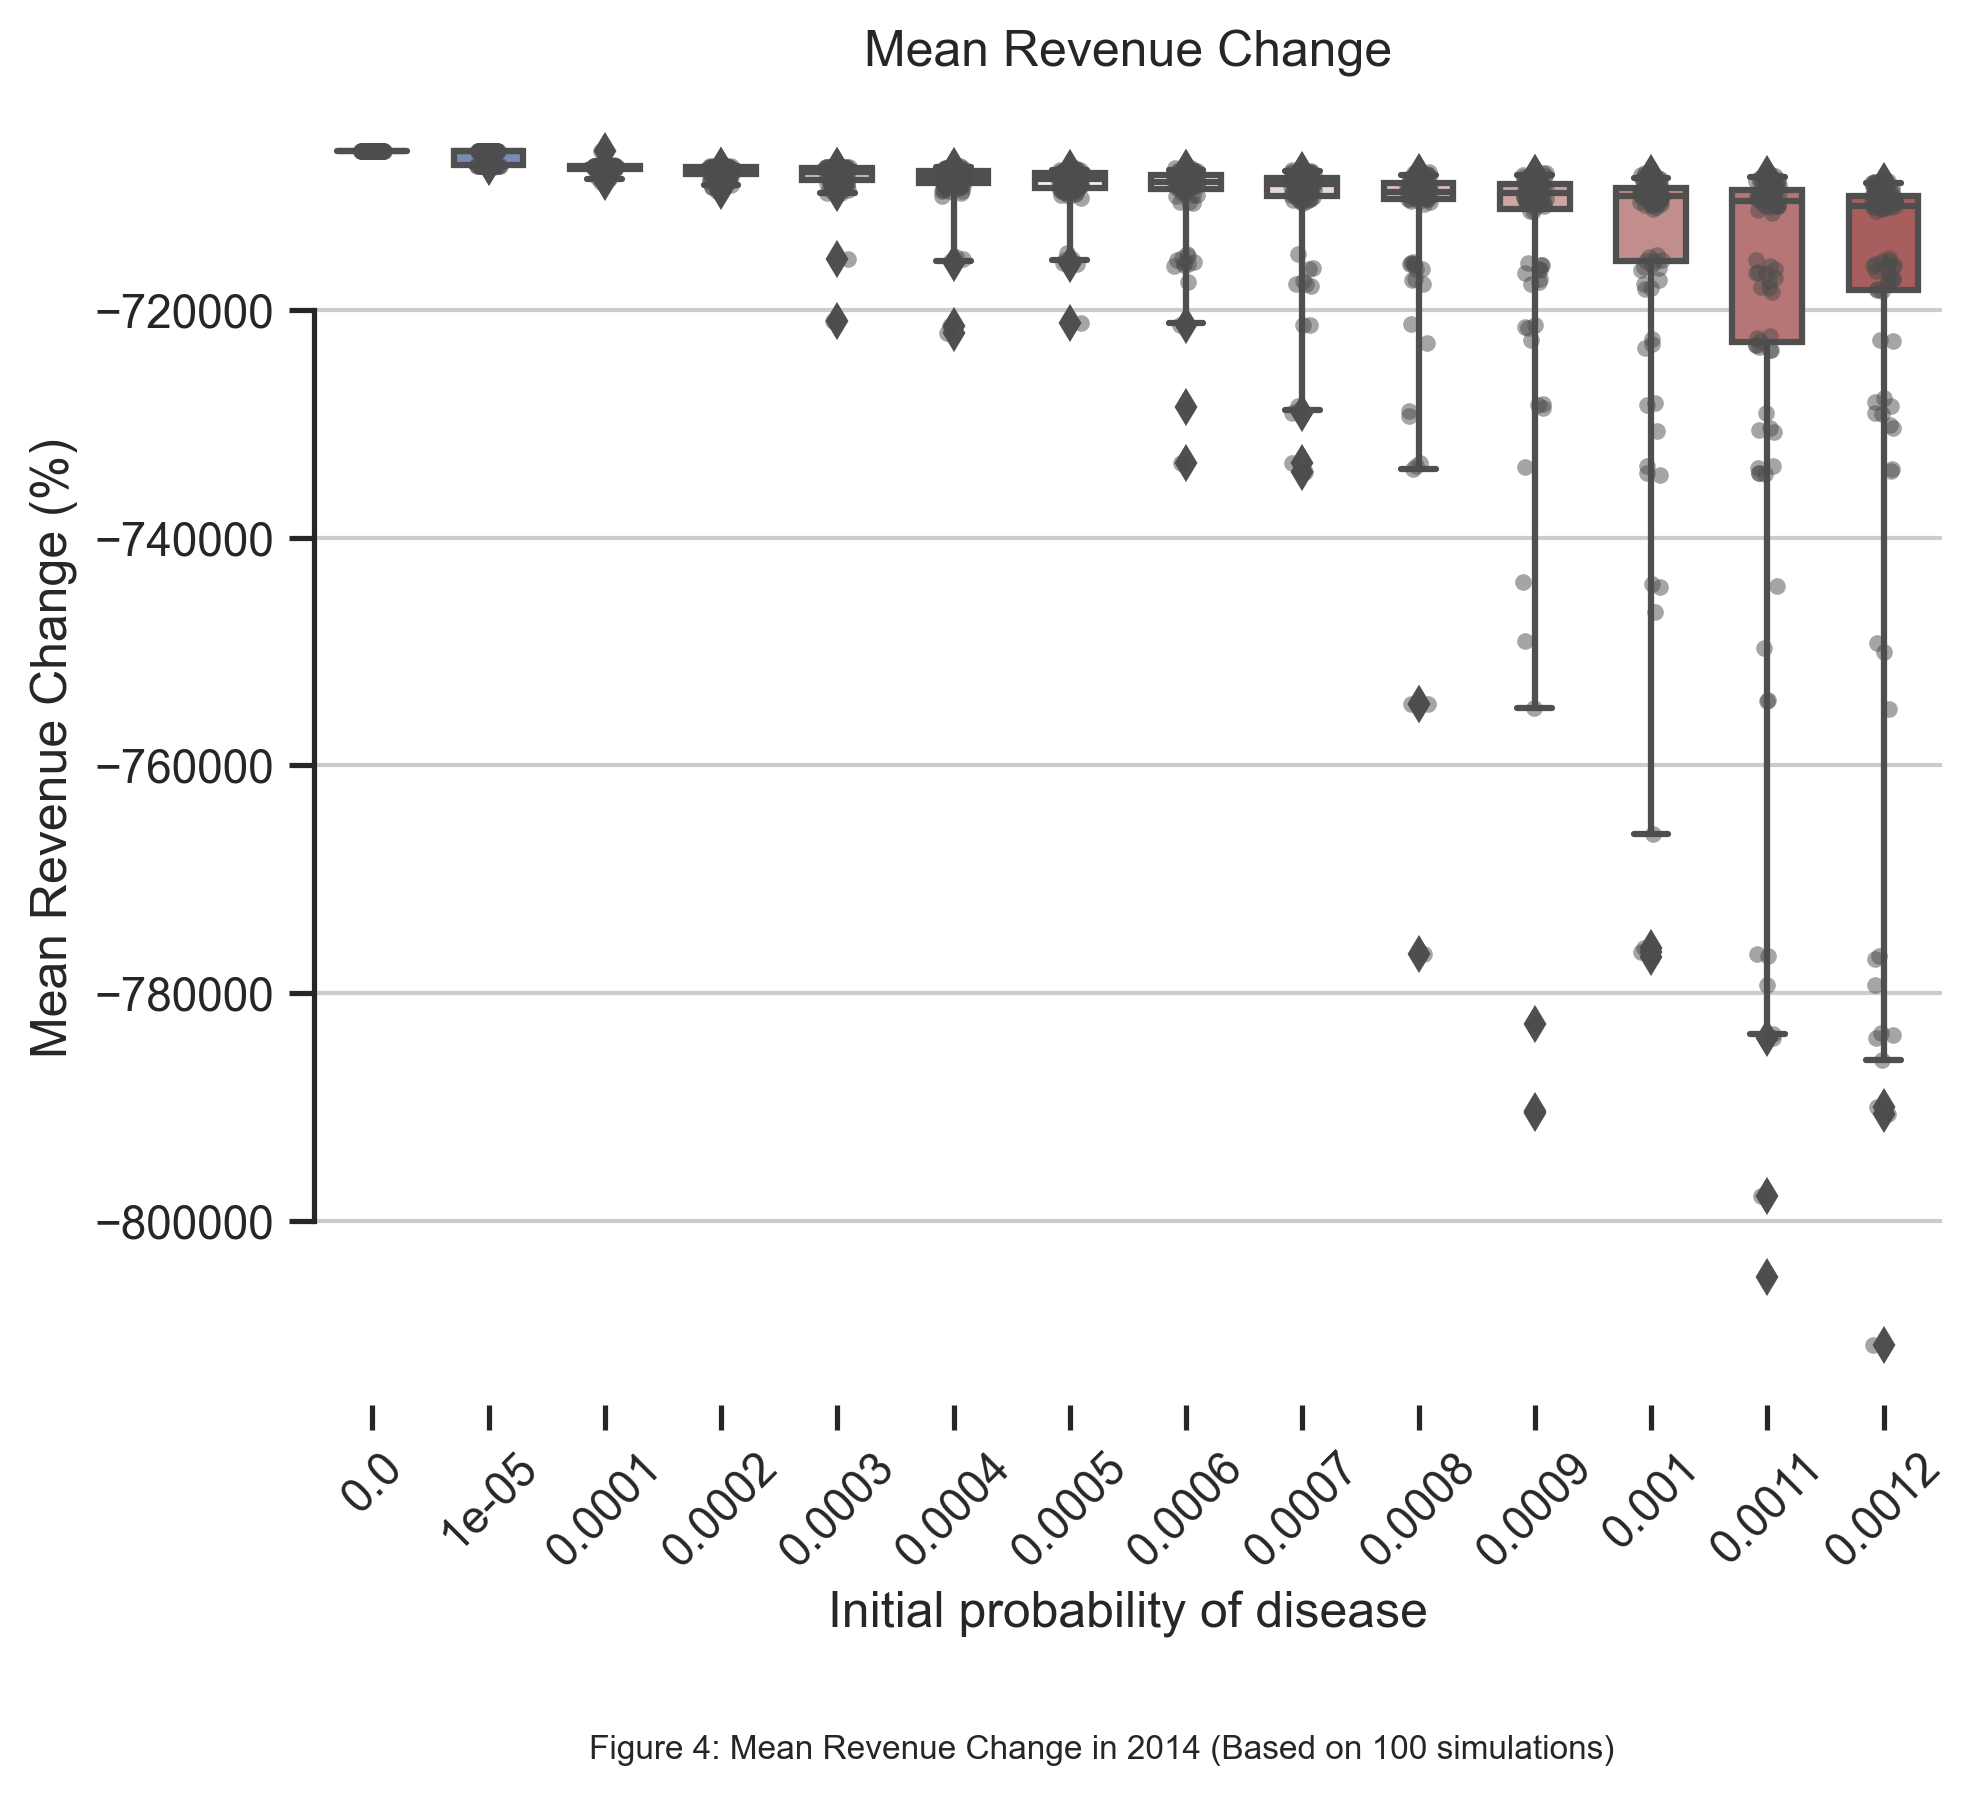

In [230]:
revenue_change_simulations_list = []

for simulation in range(0, simulations * len(p_values)):

    revenue_change_list = []

    for field in range(0, N):
        
        revenue_change = profit(plant_incidence=(y_2_array[simulation][field] / n[field]), sprays=10, variety=variety_array[field][0], infections=y_2_array[simulation][field], demand="high", )
        revenue_change_list.append(revenue_change)
        
    revenue_change_array = np.array(revenue_change_list).reshape(N, 1)
    revenue_change_simulations_list.append(revenue_change_array)
    
mean_revenue_change_simulations_list = np.mean(revenue_change_simulations_list, axis=1) * 100

# Plot Mean of Revenue Change Simulations List

# Flatten the mean_revenue_change_simulations_list
flat_mean_revenue_change_simulations_list = [item for sublist in mean_revenue_change_simulations_list for item in sublist.ravel()]

# Repeat each p_value based on the number of simulations run for it
p_values_repeated = []
for i in range(len(p_values)):
    p_values_repeated.extend([p_values[i]] * len(mean_revenue_change_simulations_list[i]) * simulations)
print(len(p_values_repeated))
# Check if lengths are the same
assert len(flat_mean_revenue_change_simulations_list) == len(p_values_repeated), \
    f"Lengths do not match: {len(flat_mean_revenue_change_simulations_list)} vs {len(p_values_repeated)}"
    
# Convert list of arrays into DataFrame
df_revenue_change = pd.DataFrame({
    'p_value': p_values_repeated, 
    'mean_revenue_change': flat_mean_revenue_change_simulations_list
})

sns.set_theme(style="ticks")

# Initialize the figure
f, ax = plt.subplots(figsize=(7, 6), dpi=300)

# Plot the disease prevalence with vertical boxes
sns.boxplot(x='p_value', y='mean_revenue_change', data=df_revenue_change, whis=[2.5, 97.5], width=.6, palette="vlag")

# Add in points to show each observation
sns.stripplot(x='p_value', y='mean_revenue_change', data=df_revenue_change, size=4, color=".3", linewidth=0, alpha=0.5)

# Tweak the visual presentation
ax.yaxis.grid(True)
ax.set(xlabel="Initial probability of disease", ylabel="Mean Revenue Change (%)")
sns.despine(trim=True, bottom=True)
ax.set_title("Mean Revenue Change")
plt.figtext(0.5, -0.05, f"Figure 4: Mean Revenue Change in {year} (Based on {simulations} simulations)", ha="center", fontsize=8, va="bottom")
plt.xticks(rotation=45)
plt.subplots_adjust(bottom=0.15)
plt.show()
